# Jupyter Demonstration Notebook

Author: Marcus D. Bloice <https://github.com/mdbloice>

Here we will perform transfer learning

First we will perform some imports:

In [234]:
import numpy as np
import pandas as pd

# Useful collection of statistics functions
from scipy import stats

# MatPlotLib is the de facto standard plotting library for Python
import matplotlib.pyplot as plt

# Python Image Library
from PIL import Image

# For scanning directories for files glob is useful as is os
import glob
import os

# SciKit Learn has many utility functions that are useful
from sklearn.model_selection import train_test_split

# For our deep learning we will use Keras, which is now included in TensorFlow
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

## Loading in the Data and Data Exploration

Now we will read in the image data.

In [2]:
image_file_list = glob.glob("/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/*.jpg")

Check its length:

In [3]:
len(image_file_list)

10015

Have a look at the first ten:

In [4]:
image_file_list[:10]

['/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0027511.jpg',
 '/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0030180.jpg',
 '/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0033715.jpg',
 '/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0030683.jpg',
 '/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0027896.jpg',
 '/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0033418.jpg',
 '/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0030322.jpg',
 '/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0028407.jpg',
 '/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0025609.jpg',
 '/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_Input/ISIC_0031926.jpg']

We can take a look at an image using some random index:

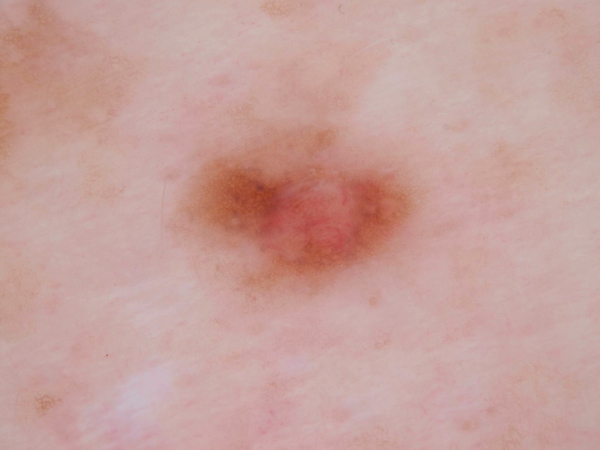

In [163]:
Image.open(image_file_list[55])

Read the CSV 

In [5]:
csv_file_location = "/home/mblo/Western-Digital/ISIC2019 Data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

We can use Pandas `read_csv()` to quickly read the file into memory:

In [13]:
csv_contents = pd.read_csv(csv_file_location)

The `head()` and `tail()` functions are useful for previewing large datasets:

In [14]:
csv_contents.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


You will notice these are floats, we will change these to integers. 

PS there are better ways of doing this column by column, but it will do for now:

In [44]:
csv_contents.MEL = csv_contents.MEL.astype(int)
csv_contents.NV = csv_contents.NV.astype(int)
csv_contents.BCC = csv_contents.BCC.astype(int)
csv_contents.AKIEC = csv_contents.AKIEC.astype(int)
csv_contents.BKL = csv_contents.BKL.astype(int)
csv_contents.DF = csv_contents.DF.astype(int)
csv_contents.VASC = csv_contents.VASC.astype(int)

In [45]:
csv_contents.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0,1,0,0,0,0,0
1,ISIC_0024307,0,1,0,0,0,0,0
2,ISIC_0024308,0,1,0,0,0,0,0
3,ISIC_0024309,0,1,0,0,0,0,0
4,ISIC_0024310,1,0,0,0,0,0,0


Let's get a count of all the values and then plot these. The `value_counts()` function returns counts for each item, in our case the number of 0s (negative diagnosis) and number of 1s (positive diagnosis): 

In [48]:
csv_contents.MEL.value_counts(sort=False)

0    8902
1    1113
Name: MEL, dtype: int64

So there are 1113 malignant melanoma in the dataset.

Because we are only interested in the second (1th) element so we will only save these:

In [50]:
mel_counts = csv_contents.MEL.value_counts(sort=False)[1]
nv_counts = csv_contents.NV.value_counts(sort=False)[1]
bcc_counts = csv_contents.BCC.value_counts(sort=False)[1]
akiec_counts = csv_contents.AKIEC.value_counts(sort=False)[1]
bkl_counts = csv_contents.BKL.value_counts(sort=False)[1]
df_counts = csv_contents.DF.value_counts(sort=False)[1]
vasc_counts = csv_contents.VASC.value_counts(sort=False)[1]

counts = [mel_counts, nv_counts, bcc_counts, akiec_counts, bkl_counts, df_counts, vasc_counts]

In [51]:
counts

[1113, 6705, 514, 327, 1099, 115, 142]

These should sum to the length of the images in the dataset:

In [59]:
# This will throw an exception if they are not equal. The -1 is the last element of the list. 
assert(np.cumsum(counts)[-1] == len(image_file_list))

To make sure we can do it visually as well:

In [73]:
print("The number of diagnoses is %s, and the number of images is %s" 
      % (np.cumsum(counts)[-1], len(image_file_list)))

The number of diagnoses is 10015, and the number of images is 10015


Make a pandas data frame of the counts:

In [76]:
counts_df = pd.DataFrame(counts, columns=["Count"], index=["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
counts_df

,Count
MEL,1113
NV,6705
BCC,514
AKIEC,327
BKL,1099
DF,115
VASC,142


Sort them in descending order:

In [84]:
counts_df.sort_values(by="Count", ascending=False)

,Count
NV,6705
MEL,1113
BKL,1099
BCC,514
AKIEC,327
VASC,142
DF,115


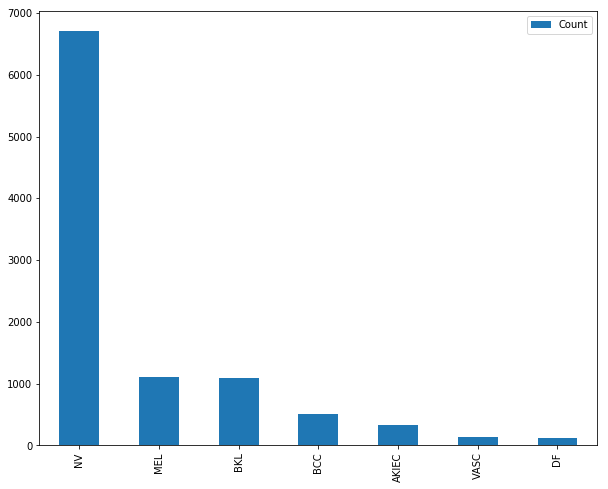

In [248]:
counts_df.sort_values(by="Count", ascending=False).plot(kind="bar", figsize=(10,8));

As you can see, we have quite an imbalanced dataset, we have many more NV lesions as MEL lesions. We also have nearly the same number of BKL lesions as MEL lesions. 

When training your neural network, you will need to account for this. You may want to use all the MEL images but sample an equal amount of NV images from the ensire set so that they are balanced. 

Also, with imbalanced datasets, it is crucial that you are very careful interpreting the "accuracy" metric of the trained model! 

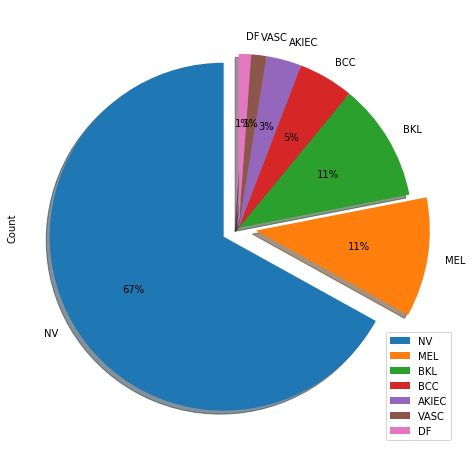

In [167]:
counts_df.sort_values(by="Count", ascending=False).plot.pie(subplots=True, 
                                                            figsize=(8,8), 
                                                            autopct='%1.0f%%', 
                                                            explode=[0.1,0.1,0,0,0,0,0],
                                                            shadow=True,
                                                            startangle=90);

## Creating the Dataset for the ML Task

Now we have a list of the images and a CSV containing the ground truth data (the labels). 

We want to construct a dataset consisting of the image data, stored in a variable `X` and each image's label, stored in a variable `y`. 

It is convention to use uppercase `X` for matrix data (in this case our images) and lower case `y` for label vectors, in this case each image's label which is either 0 for benign or 1 for malignant. 

First we search the CSV file for each image and only select those where *either* **MEL** or **NV** are 1 and ignore the rest:

In [178]:
X = []
y = []
count = 0

for image in image_file_list:
    # Keep a count of the processed images to display a progress
    count += 1
    
    # Find the label for that image and add to y
    file_name = os.path.basename(image)
    file_name = str.split(file_name, ".jpg")[0]
    row = csv_contents.loc[csv_contents['image'] == file_name]
    
    if np.array(row.MEL)[0] == 1:
        im = Image.open(image)
        im_array = np.asarray(im)
        X.append(im_array)
        y.append(1)
    elif np.array(row.NV)[0] == 1:
        im = Image.open(image)
        im_array = np.asarray(im)
        X.append(im_array)
        y.append(0)
    
    # Print the progress...
    if count % 1000 == 0:
        print("Processed %s images..." % count)

Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
Processed 4000 images...
Processed 5000 images...
Processed 6000 images...
Processed 7000 images...
Processed 8000 images...
Processed 9000 images...
Processed 10000 images...


Let's have a look at our data and ensure it looks as we expect:

In [132]:
np.shape(X)

(10015, 450, 600, 3)

In [168]:
np.shape(y)

(7818,)

The length of y should be the same as the number NV and MEL images in the dataset, so let's confirm that:

In [177]:
counts_df.loc['MEL'] + counts_df.loc['NV']

Count    7818
dtype: int64

That should match up.

We now have our image data stored in `X` and our label data stored in `y`. Let's have a look at a random label and image:

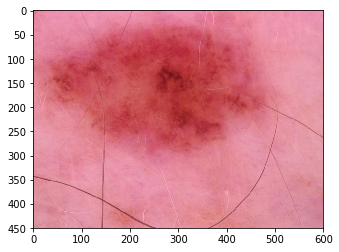

In [250]:
plt.imshow(X[55]);

In [184]:
y[55]

0

Remember that 0 means benign nevus, while 1 means malignant melanoma.

**Important Note** the images we loaded in to `X` are not preprocessed in any way! For any machine learning task, there is a certain amount of preprocessing that must be performed, for example to normalise the pixel values and to convert the images from 0-255 integer arrays to floats between 0-1. We will see this later in the demo of the pre-trained network.

### Creating a train and test split

In order to properly test your network you must train it using a training set, and test it on a held back dataset, called a test set. There are utility functions available in SciKit Learn (Python's machine learning library) that can do this for you:

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
print("Training set size: %s\nTest set size: %s" % (len(X_train), len(X_test)))

Training set size: 5863
Test set size: 1955


However, if you observe once again the distribution of the labels, you will see they are skewed:

In [241]:
stats.itemfreq(y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[   0, 5025],
       [   1,  838]])

The same is true of the test set:

In [242]:
stats.itemfreq(y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[   0, 1680],
       [   1,  275]])

This is a problem for several reasons. One problem is that you may inerpret the accuracy of the network incorrectly. For example, say your model always predicted 0 for any image passed into it, then its accuracy would be, given:

$$
\text{Accuracy} = \frac{\mathit{TP} + \mathit{TN}}{P + N} = \frac{1680+0}{1680+275} = \frac{1680}{1955} = 0.859
$$

of more simply:

$$
\text{Accuracy} = \frac{\text{Correct predictions}}{\text{Total predictions made}}
$$

Where $\mathit{TP}$ are the number of true positives, $\mathit{TN}$ is the number true negatives, and $P$ is the number of positive samples and $N$ is the number of negative samples in the dataset.

or 

$$
\text{Accuracy} = \frac{\sum \text{true positives} + \sum \text{true negatives}}{\sum \text{dataset size}} = \frac{1680}{1955} = 0.859
$$

The $\sum$ of the true positives is 1680, as our network predicted that all images in the test set were positive, and $\sum$ of the true negatives is 0, again as out network predicted that all images in the test were positive and never negative, so:

$$
\text{Accuracy} = \frac{1680 + 0}{1955}
$$

which gives:

$$
\text{Accuracy} = 0.859
$$

That is an accuracy of 86% merely for guessing the same class for any input!

For your assignment you will need to properly balance your dataset, or think of some other method to compensate for the class imbalance. When evaluating your results using a test set that is imbalanced, use other metrics such as SciKit Learn's balanced accuracy score `sklearn.metrics.balanced_accuracy_score()`, the ROC-AUC metric, or by closely examining the confusion matrix (see `sklearn.metrics.confusion_matrix()`).

# Transfer Learning

## Using a Pre-trained Network

Using the deep learning library Keras we can use pretrained networks that were trained for long amounts of time on the ImageNet dataset. In this example we will download the VGG16 network which was the winner of the ImageNet challenge several years ago. Pre-trained networks are an example of "transfer learning". 

First we shall load the pretrained network:

In [186]:
vgg16 = keras.applications.vgg16.VGG16(weights='imagenet')

This will download the pre-trained network if you have not already done so in the past. It is approximately 600MB in size. 

Now we can take a look at the structure of the network:

In [187]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [264]:
img_path = '/home/mblo/Downloads/parrot3.jpg'
img = preprocessing.image.load_img(img_path, target_size=(224, 224))
x = preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [265]:
np.shape(x)

(1, 224, 224, 3)

Let's have a look at the image before and after preprocessing:

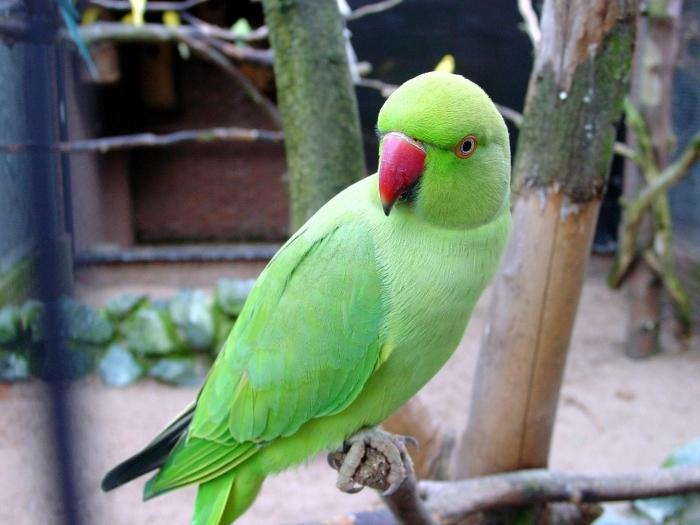

In [266]:
Image.open(img_path)

Now after preprocessing:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


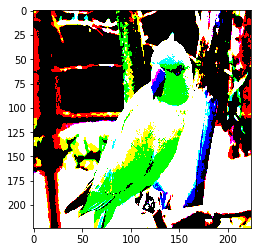

In [267]:
plt.imshow(x.reshape((224,224,3)));

In [262]:
print(vgg16.predict(x))

[[5.16854561e-05 2.85156275e-04 2.33612791e-08 8.05805733e-09
  5.91868137e-08 5.92433658e-09 1.85035010e-08 3.51743284e-03
  5.16474480e-03 4.11692156e-07 1.94334443e-05 1.43108955e-02
  1.59011382e-04 1.34960464e-06 6.48999048e-05 9.30689712e-05
  4.28445026e-04 1.37304029e-04 3.65325308e-04 9.11162147e-07
  1.31811350e-06 1.22091398e-04 7.37899200e-07 1.50397420e-04
  2.59357330e-06 7.40365977e-06 1.85300416e-06 1.43186971e-05
  7.59863894e-07 7.20083335e-08 1.12706775e-05 5.43639435e-05
  2.21557548e-05 2.00806110e-08 3.33509576e-08 8.60316391e-07
  7.55079327e-06 2.08317829e-06 8.29161877e-08 4.49774734e-06
  1.06981906e-05 4.88177889e-08 6.27415284e-06 1.63159811e-07
  1.13663553e-07 8.89502303e-08 3.64859602e-06 8.38465780e-07
  3.32496057e-07 1.74954977e-07 4.62374089e-07 1.83764732e-05
  2.95922490e-07 1.24272731e-06 6.21496952e-08 2.80154700e-06
  2.34140748e-06 1.47662334e-07 2.04757370e-07 4.70282248e-06
  1.02406034e-06 3.96725511e-07 1.68450595e-06 1.43206762e-07
  2.7331

What we have here is a probability distribution across the 1000 classes of ImageNet.

We need to decode this into something we can read and we will also format the probibilties to percentages, we can use the Keras `decode_predictions()` function for this:

In [268]:
res = decode_predictions(vgg16.predict(x), top=3)[0]
print("-----\n1:\nClass: %s\nProbability: %.2f%%\n-----\n" % (res[0][1], res[0][2]*100))
print("-----\n2:\nClass: %s\nProbability: %.2f%%\n-----\n" % (res[1][1], res[1][2]*100))
print("-----\n3:\nClass: %s\nProbability: %.2f%%\n-----\n" % (res[2][1], res[2][2]*100))

-----
1:
Class: lorikeet
Probability: 51.17%
-----

-----
2:
Class: macaw
Probability: 39.26%
-----

-----
3:
Class: toucan
Probability: 8.75%
-----



Summing the prediction probabilities for all 1000 classes will result in 1.

## Fine-Tuning the Network

As part of your assignment, you need to fine tune a neural network. 

This means you use a pre-trained network, such as the one above, but you remove the topmost layers (for example all the fully connected layers) and add new randomly initialised layers that you then train with your own data (fine tuning).

When you are fine-tuning, it is important that you freeze the lower layers of the network, so that when you training it with your data, that you only train the top most layers. The lower layers contain features and filters that you wish to keep.

Also, the final layer needs to match the size of new classification task, in the case of this project that is 2.

1. Download a pre-trained network
2. Remove the top most layers (the final layers of the network)
3. Freeze these layers so that they are not updated during training
4. Add new randomly initialised layers to the network
5. Train the network on your data (which will only update the new layers) 

See <https://keras.io/applications/> for further information. 